# Simulation of Experiments
### new ads and mature ads, SBL-DMD, no long-term effects

In [61]:
# import packages
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from datetime import time, datetime
import datetime as dt
import statsmodels.api as sm
import argparse
import math
from time import time 
import random



#SimOutput class, store and output simulation results
class SimOutput():
    def __init__(self, impressions, clicks, total_cost, target_cpc, current_bid, is_new, opt):
        self.impressions=impressions
        self.clicks=clicks
        self.total_cost=total_cost
        self.target_cpc=target_cpc
        self.current_bid=current_bid
        self.is_new = is_new
        self.opt = opt
        np.seterr(divide='ignore',invalid='ignore')
    
    #基本冷启动summary stat
    def eCTR(self):
        #广告点击率的分布和平均值
        ectr = self.clicks/self.impressions
        ectr = ectr[~np.isnan(ectr)]
        print("Median of average eCTR: ", np.median(ectr))
        print("Mean of average eCTR: ", np.mean(ectr))
        plt.hist(self.clicks/self.impressions, bins=100)        
        plt.xlabel('eCTR')
        plt.ylabel('Number of Ads')
        plt.title('Histogram of eCTR')
    
        
    def impression_click_scatter(self):
        plt.figure(12, figsize=[15, 10])   
        plt.subplot(221)
        #曝光数累计分布概率
        plt.hist(self.impressions, bins=150 ,cumulative=True, histtype='step', density=True)        
        plt.xlabel('Impressions')
        plt.ylabel('Cdf')
        plt.title('Cumulative Distribution Function')
        
        plt.subplot(222)
        #点击数累计分布概率
        plt.hist(self.clicks, bins=150 ,cumulative=True, histtype='step', density=True)        
        plt.xlabel('Clicks')
        plt.ylabel('Cdf')
        plt.title('Cumulative Distribution Function')
        
        plt.subplot(212)
        #曝光和点击的散点图，可能需要改进scale
        total_impressions = self.impressions.sum()
        total_clicks = self.clicks.sum()
        plt.scatter(self.impressions, self.clicks, color='r')
        #plt.xlim(0, total_impressions*0.2)
        #plt.ylim(0, total_clicks*0.2)
        plt.xlabel('Impressions')
        plt.ylabel('Clicks')
        plt.title('Impressions v.s. Clicks')
        plt.show()
    
    
    
 
    def basic_outputs(self):
        print('Revenue:', self.total_cost.sum())
        print('L1-Cold Start Reward:', sum(opt.reward/opt.target_click*np.minimum(click_feedback, opt.target_click)*is_new))
        print('Total Objective Value:', self.total_cost.sum()+sum(opt.reward/opt.target_click*np.minimum(click_feedback, opt.target_click)*is_new))
        print('L0-Cold Start Reward:', opt.reward*(click_feedback*is_new>=opt.target_click).sum())
        print('Target Revenue:',sum(click_feedback*target_bid_np))
        print('Cold Start Success Rate:',(click_feedback*is_new>=opt.target_click).sum()/is_new.sum())




  






In [4]:
#PID system for cold start, current practice on Platform O is uniformaly increasing
#bids of new ads, e.g., 2 times of target_bid, then let PID system dynamically change the bid
def PID_sys(current_cpc, target_cpc, current_ecpc):
    k_p = 0.79
    error = target_cpc - current_ecpc
    current_cpc += np.clip(k_p*error, -0.1*current_cpc, 0.1*current_cpc)
    current_cpc = np.clip(current_cpc, 0.5*target_cpc, 1.5*target_cpc)
    return current_cpc

In [58]:
#true CTR generating function (linear), we use fix effect models to get CTR constants for both 
#new ads and mature ads. But due to the data security, we do not disclose the joint distribution of 
#contexts information (features). Instead we only use marginal distribution of three
#demographic features including gender, location, and age, and synthetically generate the 
#corresponding coefficient of CTR linear model


#context generate function
gender_pdf = np.array([0.5, 0.5])#marginal distribution of gender. [male, female]
location_pdf = np.array([0.22, 0.46, 0.32])#marginal distribution of city level. [big city, mid city, small city]
age_seg_pdf = np.array([0.46, 0.34, 0.20])#distribution of age. [<24,  24~30, >30]
dim_context  = int(np.shape(gender_pdf)[0]+np.shape(location_pdf)[0]+np.shape(age_seg_pdf)[0] + 1)
def context_generate(gender_ratio = gender_pdf, loc_ratio = location_pdf, age_ratio = age_seg_pdf):
    a = np.random.multinomial(1, gender_pdf, size=1)
    b = np.random.multinomial(1, location_pdf, size=1)
    c = np.random.multinomial(1, age_ratio, size=1)
    return np.concatenate((a, b, c, 1), axis=None)#last one is constant 1 for fixed CTR

#load joint information of ctr fixed effect coefficient, and target bid (CPC)
ctr_bid_np = np.load('ctr_bid_data.npy')#we sampled 300 data points, the first column is CTR, the second is CPC
#note the first 200 rows are marure ads and last 100 rows are new ads
def generate_ad(n, new_raito = 0.30, dim_context = dim_context, data = ctr_bid_np):
    #n is the total number of ads, new_raito is ratio of new ads
    num_new_ad = int(n*new_raito)
    num_mature_ad = n - num_new_ad
    sampled_ctr = data[:, 0]
    sampled_cpc = data[:, 1]
    
    #initialize output data: 
    is_new_index = np.zeros(n)
    target_cpc = np.zeros(n)
    coefficient_ctr_model = np.zeros([n, dim_context])
    #generate bid, true CTR model
    for i in range(n):
        index = 0
        if i < num_mature_ad:
            is_new_index[i] = 0
            index = np.random.choice(np.arange(0,200))
        else:
            is_new_index[i] = 1
            index = np.random.choice(np.arange(200,300))
        
        target_cpc[i] = sampled_cpc[index]
        coefficient_ctr_model[i, 0:-1] = np.random.uniform(-0.05,0.05,dim_context-1)
        coefficient_ctr_model[i, -1] = sampled_ctr[index]
    return np.int32(is_new_index), target_cpc, coefficient_ctr_model

# Hyperparameter Setting

In [175]:
# hyperparameters settings: first price, CPC
import sys
sys.argv=['']
del sys
parser = argparse.ArgumentParser()

#Default cold start parameter - the cold start value = reward*I(clicks>=target_click)
parser.add_argument('--total_ads', type=int, default=1000, help='total number of ads for simulation')
parser.add_argument('--new_ad_ratio', type=float, default=0.3, help='ratio of new ads')
parser.add_argument('--total_pv', type=int, default=3000000, help='loaded total page views in one cold start horizon for simulation')
parser.add_argument('--reward', type=float, default=400000, help='reward of cold start')
parser.add_argument('--target_click', type=int, default=1000, help='target click')
parser.add_argument('--alpha', type=float, default=1e-3, help='target click/max_pv')


#conditions of ads to get ouf of the cold start phase
parser.add_argument('--budget_limit', type=int, default=5e5, help='set an uniform budget limit on ads')
#once new ads hit target click = 1000, it is labeled mature ads. this default budget is enough for cold start
parser.add_argument('--cs', type=int, default=1, help='if using SBL-DMD in parallel simulation')
parser.add_argument('--exp', type=int, default=1, help='if using two-sided experiments')


#two side exp parameters
parser.add_argument('--ad_treatment_ratio', type=float, default=0.4, help='range from 0 to 0.5')
parser.add_argument('--pv_treatment_ratio', type=float, default=0.4, help='range from 0 to 0.5')



opt = parser.parse_args()



In [233]:
is_new_index, target_cpc, coefficient_ctr_model = generate_ad(n = opt.total_ads, 
                                                                          new_raito = opt.new_ad_ratio)

## Part I: Two parallel simulation using PID or SBL-DMD

### I.1 PID baseline

In [183]:
opt.cs = 0#using PID

lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)


total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
new_ad_index = np.where(is_new_index==1)[0]



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
if opt.cs == 0:
    for i in range(opt.total_ads):
        if is_new_index[i]==1:
            current_cpc[i] = 3*target_cpc[i]
      

            
#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.zeros(opt.total_ads)
    pCTR = np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1)
    if opt.cs == 1:
        current_bid_np = target_cpc + lambda_
    else:
        current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if opt.cs==1:
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        #using PID
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    if opt.cs==1:
        #SBL-DMD, using dual mirror descent to update lambda
        stepsize = 10
        lambda_ += stepsize*opt.alpha
        lambda_[max_index] -= stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_index
        lambda_ = np.maximum(lambda_, 0)*is_new_index
        
        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    if opt.cs==0 and i/1000==999:
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        
    
   

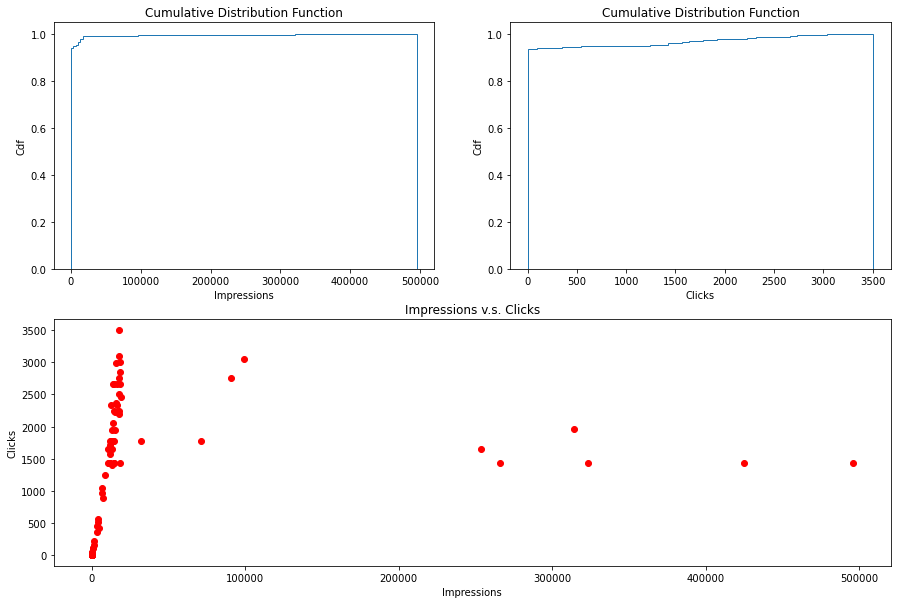

Revenue: 26300123.185501173
Revenue of New Ads: 2849394.4952770798
L1-Cold Start Reward: 2667600.0
Total Objective Value: 28967723.185501173
L0-Cold Start Reward: 2000000
Cold Start Success Rate: 0.016666666666666666


In [184]:
#store the simulation results
total_clicks_pid = np.copy(total_clicks)
total_impressions_pid = np.copy(total_impressions)
total_cost_pid = np.copy(total_cost)
final_bid_pid = np.copy(current_cpc)
final_lambda_pid = np.copy(lambda_)
sys_out=SimOutput(total_impressions, total_clicks, total_cost, target_cpc, current_cpc)
sys_out.impression_click_scatter()
print('================================================')
print('Revenue:', np.sum(total_cost))
print('Revenue of New Ads:', np.sum(total_cost*is_new_index))
print('L1-Cold Start Reward:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))
print('Total Objective Value:', np.sum(total_cost)+np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))

print('================================================')
print('L0-Cold Start Reward:', opt.reward*(total_clicks*is_new_index>=opt.target_click).sum())
print('Cold Start Success Rate:',(total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum())




### I.2 SBL-DMD

In [185]:
opt.cs = 1#using SBL-DMD

lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)


total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
new_ad_index = np.where(is_new_index==1)[0]



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
if opt.cs == 0:
    lambda_ = np.zeros(opt.total_ads)
    for i in range(opt.total_ads):
        if is_new_index[i]==1:
            current_cpc[i] = 3*target_cpc[i]
    
            
#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.zeros(opt.total_ads)
    pCTR = np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1)
    if opt.cs == 1:
        current_bid_np = target_cpc + lambda_
    else:
        current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index#if using PID
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if opt.cs==1:
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        #using PID
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    if opt.cs==1:
        #SBL-DMD, using dual mirror descent to update lambda
        stepsize = 10
        lambda_ += stepsize*opt.alpha
        lambda_[max_index] -= stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_index
        lambda_ = np.maximum(lambda_, 0)*is_new_index
        
        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    if opt.cs==0 and i/1000==999:
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        
    

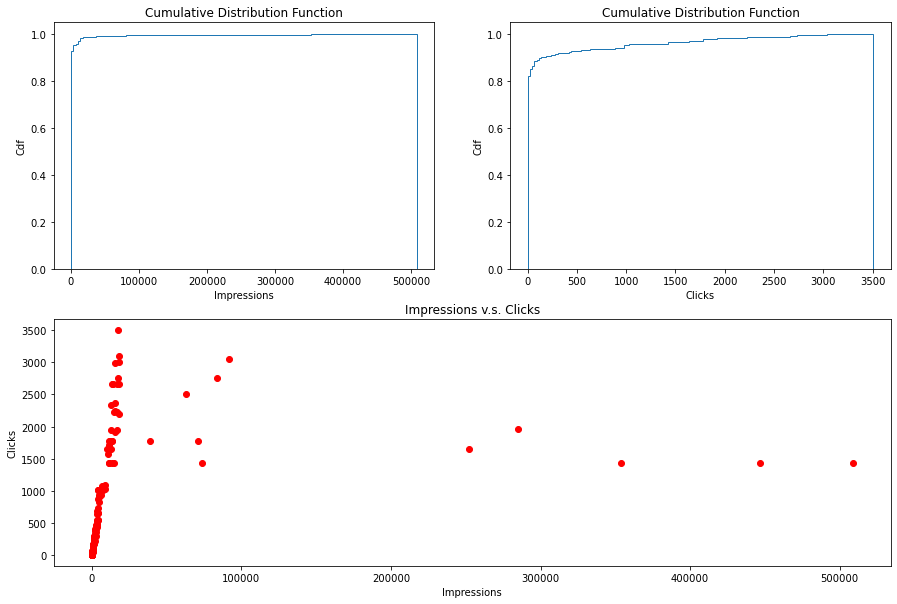

Revenue: 25063459.726171397
Revenue of New Ads: 3676758.6822560467
L1-Cold Start Reward: 15517200.0
Total Objective Value: 40580659.7261714
L0-Cold Start Reward: 6400000
Cold Start Success Rate: 0.05333333333333334


In [186]:
#store the simulation results
total_clicks_sbl = np.copy(total_clicks)
total_impressions_sbl = np.copy(total_impressions)
total_cost_sbl = np.copy(total_cost)
final_bid_sbl = np.copy(current_cpc)
final_lambda_sbl = np.copy(lambda_)
sys_out=SimOutput(total_impressions, total_clicks, total_cost, target_cpc, current_cpc)
sys_out.impression_click_scatter()
print('================================================')
print('Revenue:', np.sum(total_cost))
print('Revenue of New Ads:', np.sum(total_cost*is_new_index))
print('L1-Cold Start Reward:', np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))
print('Total Objective Value:', np.sum(total_cost)+np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_index))

print('================================================')
print('L0-Cold Start Reward:', opt.reward*(total_clicks*is_new_index>=opt.target_click).sum())
print('Cold Start Success Rate:',(total_clicks*is_new_index>=opt.target_click).sum()/is_new_index.sum())





In [ ]:
#gound true increase = 0.053 - 0.016 = 3.7%

# Part II: One side experiments

### II.1 Ad side experiments

In [242]:
print('Ad side randomized experiment')
print('# of new ads in treatment condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
print('# of new ads in control condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))

#randomly assign new ads into treatment and control groups
is_new_treatment = np.zeros(opt.total_ads)
is_new_control = np.zeros(opt.total_ads)

new_ad_index = np.where(is_new_index==1)[0]
treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                          int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
    is_new_treatment[treatment_new_ad_index[i]] = 1
    is_new_control[control_new_ad_index[i]] = 1
    

lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click

total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_control[i] == 1:
        #new control ads
        current_cpc[i] = 3*target_cpc[i]

            
#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.copy(target_cpc)
    pCTR = np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1)
    #for ad_index in new_ad_index:
    #    if is_new_treatment[ad_index] > 0:
    #        current_bid_np[ad_index] += lambda_[ad_index]
    #    if is_new_control[ad_index] > 0:
    #        current_bid_np[ad_index] = current_cpc[ad_index]
    current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control + lambda_*is_new_treatment
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if opt.cs==1:
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(treatment_new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        #using PID
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    #SBL-DMD, using dual mirror descent to update lambda
    stepsize = 10
    lambda_ += stepsize*opt.alpha
    lambda_[max_index] -= stepsize*pCTR[max_index]

    #upper bound the bounus, and mature ads with 0 bonus
    lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
    lambda_ = np.maximum(lambda_, 0)*is_new_treatment

    #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
    lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    
    if i/1000==999:
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = current_cpc*is_new_control
    
   

Ad side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (SBL-DMD) 120


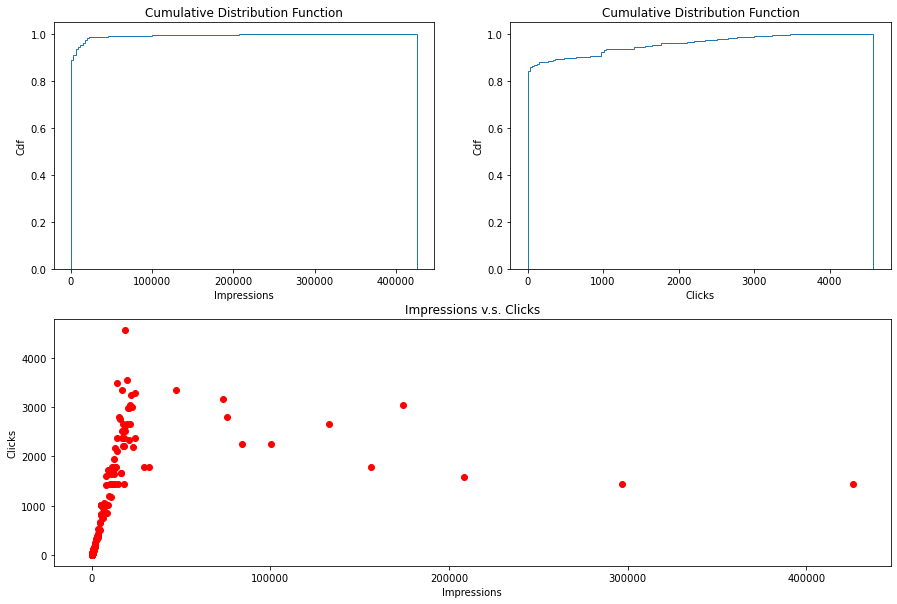

Cold Start Success Rate in Treatment: 0.23333333333333334
Cold Start Success Rate in Control: 0.025
Cold Start Success Value in Treatment: 17736400.0
Cold Start Success Value in Control: 1458000.0


In [244]:
#store the simulation results
total_clicks_ad_side = np.copy(total_clicks)
total_impressions_ad_side = np.copy(total_impressions)
total_cost_ad_side = np.copy(total_cost)
final_bid_ad_side = np.copy(current_cpc)
final_lambda_ad_side = np.copy(lambda_)
is_new_treatment_ad_side = np.copy(is_new_treatment)
is_new_control_ad_side = np.copy(is_new_control)
sys_out=SimOutput(total_impressions, total_clicks, total_cost, target_cpc, current_cpc)
sys_out.impression_click_scatter()

print('================================================')
print('Cold Start Success Rate in Treatment:',(total_clicks*is_new_treatment>=opt.target_click).sum()/is_new_treatment.sum())
print('Cold Start Success Rate in Control:',(total_clicks*is_new_control>=opt.target_click).sum()/is_new_control.sum())
print('================================================')
print('Cold Start Success Value in Treatment:',np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_treatment))
print('Cold Start Success Value in Control:',np.sum(opt.reward/opt.target_click*np.minimum(total_clicks, opt.target_click)*is_new_control))




### II.2 UV side experiments

In [215]:
lambda_ = opt.reward/opt.target_click/2*np.ones(opt.total_ads)
beta_ = opt.reward/opt.target_click*np.ones(opt.total_ads)

total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_clicks_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs
total_clicks_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs

total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_impressions_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs
total_impressions_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs

total_cost = np.zeros(opt.total_ads)#accumulated cost of ads

coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067
new_ad_index = np.where(is_new_index==1)[0]



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_index[i]==1:
        current_cpc[i] = 3*target_cpc[i]


#simulation starts
for i in range(opt.total_pv):

    ##########################generate context##########################
    contexts = context_generate()
    uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                    p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]

    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.zeros(opt.total_ads)
    pCTR = np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1)
    if uv_condition == 't':
        current_bid_np = target_cpc + lambda_
    elif uv_condition == 'c':
        current_bid_np = target_cpc*(1-is_new_index) + current_cpc*is_new_index
    else:
        current_bid_np = target_cpc
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if uv_condition == 't':
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]
        if uv_condition == 't':
            total_clicks_t[max_index] += 1
        elif uv_condition == 'c':
            total_clicks_c[max_index] += 1
    if uv_condition == 't':
        total_impressions_t[max_index] += 1
    elif uv_condition == 'c':
        total_impressions_c[max_index] += 1
    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    if uv_condition == 't':
        #SBL-DMD, using dual mirror descent to update lambda
        stepsize = 10
        lambda_ += stepsize*opt.alpha
        lambda_[max_index] -= stepsize*pCTR[max_index]

        #upper bound the bounus, and mature ads with 0 bonus
        lambda_ = np.minimum(lambda_, beta_)*is_new_index
        lambda_ = np.maximum(lambda_, 0)*is_new_index
        
        #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
        lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    if i/1000==999:
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        
    

In [216]:

print('================================================')
print('Cold Start Success Rate in Treatment:',(total_clicks_t*is_new_index>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_index.sum())
print('Cold Start Success Rate in Control:',(total_clicks_c*is_new_index>=opt.target_click*opt.pv_treatment_ratio).sum()/is_new_index.sum())


Cold Start Success Rate in Treatment: 0.023333333333333334
Cold Start Success Rate in Control: 0.006666666666666667


# Part III: Two side experiments

In [239]:
print('Ad side randomized experiment')
print('# of new ads in treatment condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))
print('# of new ads in control condition (SBL-DMD)', int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio))

#randomly assign new ads into treatment and control groups
is_new_treatment = np.zeros(opt.total_ads)
is_new_control = np.zeros(opt.total_ads)

new_ad_index = np.where(is_new_index==1)[0]
treatment_new_ad_index = np.random.choice(new_ad_index, int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

control_new_ad_index = np.random.choice(np.setdiff1d(new_ad_index, treatment_new_ad_index), 
                                          int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio), replace=False)

for i in range(int(opt.total_ads*opt.new_ad_ratio*opt.ad_treatment_ratio)):
    is_new_treatment[treatment_new_ad_index[i]] = 1
    is_new_control[control_new_ad_index[i]] = 1
    

lambda_ = np.zeros(opt.total_ads)
beta_ = opt.reward/opt.target_click


total_impressions = np.zeros(opt.total_ads)#accumulated number of impressions
total_impressions_two_t = np.zeros(opt.total_ads)#accumulated number of impressions in treatment UVs & ads
total_impressions_two_c = np.zeros(opt.total_ads)#accumulated number of impressions in control UVs & ads
total_clicks = np.zeros(opt.total_ads)#accumulated number of clicks
total_clicks_two_t = np.zeros(opt.total_ads)#accumulated number of clicks in treatment UVs & ads
total_clicks_two_c = np.zeros(opt.total_ads)#accumulated number of clicks in control UVs & ads

total_cost = np.zeros(opt.total_ads)#accumulated cost of ads
coefficient_ctr_pred_model = np.zeros([opt.total_ads, dim_context]) 
#assume for mature ads, we know exactly the true CTR model
for i in range(opt.total_ads):
    if is_new_index[i]==0:
        coefficient_ctr_pred_model[i] = coefficient_ctr_model[i]
    else:
        #for new ads, initialize average of real CTR and mean CTR = 0.067 (over all new ads)
        #to mimic real situation, reco sys has partial prior knowledge of new ads
        #typically initialize by avergae over all ads with the same industry
        coefficient_ctr_pred_model[i, -1] = 0.5*coefficient_ctr_model[i, -1]+0.5*0.067



#before simulation starts, if using PID, increasing initial bid price of new ads and lambda=0
#if using SBL-DMD, adding bonus bid lambda to target_cpc
current_cpc = np.zeros(opt.total_ads)
for i in range(opt.total_ads):
    if is_new_control[i] == 1:
        #new control ads
        current_cpc[i] = 3*target_cpc[i]

            
#simulation starts
for i in range(opt.total_pv):


    ##########################generate context##########################
    contexts = context_generate()
    uv_condition = np.random.choice(['t', 'c', 'ow'], 1, 
                                p=[opt.pv_treatment_ratio, opt.pv_treatment_ratio, 1-2*opt.pv_treatment_ratio])[0]



    ##########################calculate eCPM and Auction##########################
    #calculate pCTR and eCPM = pCTR*bid
    current_bid_np = np.copy(target_cpc)
    pCTR = np.minimum(np.matmul(coefficient_ctr_pred_model, contexts), 1)
    if uv_condition == 't':
        #block ads in control condition by setting bid=-10000
        current_bid_np = current_bid_np*(1-is_new_control) - 10000*is_new_control + lambda_*is_new_treatment
    elif uv_condition == 'c':
        #block ads in treatment condition
        current_bid_np = current_bid_np*(1-is_new_control) + current_cpc*is_new_control - 10000*is_new_treatment
    else:
        current_bid_np = current_bid_np*(1-is_new_control) - 10000*is_new_control - 10000*is_new_treatment
    current_bid_np -= 10000*np.greater(total_cost, opt.budget_limit*np.ones(opt.total_ads))
    ecpm = pCTR * current_bid_np
    #ranking
    max_index = 0
    if opt.cs==1:
        #exploration and exploitation
        if np.random.rand(1)<=1/(50+(1+i)**(1/3)):
            max_index = np.random.choice(treatment_new_ad_index, 1)[0]
        else:
            max_index = np.argmax(ecpm, axis=0)
    else:
        #using PID
        max_index = np.argmax(ecpm, axis=0)
    
    
    ##########################click feedback and cost reduction##########################  
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]
        
    total_impressions[max_index] += 1
    #get the feedback
    real_ctr = np.matmul(coefficient_ctr_model[max_index], contexts)
    is_clicked = np.random.binomial(1, max(0, min(real_ctr, 1)))
    if is_clicked == 1:#if clicked
        total_clicks[max_index] += 1
        total_cost[max_index] += target_cpc[max_index]
        if uv_condition == 't':
            total_clicks_two_t[max_index] += 1
        elif uv_condition == 'c':
            total_clicks_two_c[max_index] += 1
    if uv_condition == 't':
        total_impressions_two_t[max_index] += 1
    elif uv_condition == 'c':
        total_impressions_two_c[max_index] += 1

    ##########################update pCTR prediction model##########################
    if is_new_index[max_index]>0:#only update ctr model for new ads since we assume mature ad prediction is accurate
        coefficient_ctr_pred_model[max_index] += 0.01*(is_clicked-pCTR[max_index])*contexts#SGD for linear models
    
    ##########################update lambda or PID##########################
    #SBL-DMD, using dual mirror descent to update lambda
    stepsize = 10
    lambda_ += stepsize*opt.alpha
    lambda_[max_index] -= stepsize*pCTR[max_index]

    #upper bound the bounus, and mature ads with 0 bonus
    lambda_ = np.minimum(lambda_, beta_)*is_new_treatment
    lambda_ = np.maximum(lambda_, 0)*is_new_treatment

    #if accumulated clicks reach the target, then labeled as mature ads and no more bid bonus 
    lambda_ = np.less(total_clicks, opt.target_click*np.ones(opt.total_ads))*lambda_
    
    if i/1000==999:
        #using PID system to update current bid
        current_ecpc = total_cost/(total_clicks+0.01)#compute ecpc, +0.01 to avoid 0/0=NaN
        current_cpc = PID_sys(current_cpc,target_cpc,current_ecpc)
        current_cpc = current_cpc*is_new_control
    
   

Ad side randomized experiment
# of new ads in treatment condition (SBL-DMD) 120
# of new ads in control condition (SBL-DMD) 120


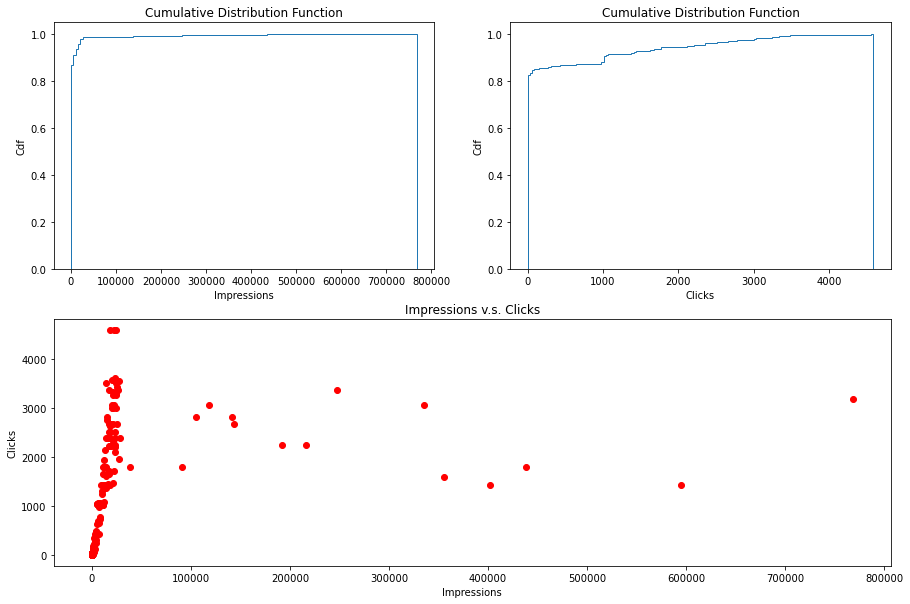

Cold Start Success Rate in Treatment: 0.3416666666666667
Cold Start Success Rate in Control: 0.075
Cold Start Success Value in Treatment: 8280800.0
Cold Start Success Value in Control: 1592000.0


In [240]:
#store the simulation results
total_clicks_two_side = np.copy(total_clicks)
total_impressions_two_side = np.copy(total_impressions)
total_cost_two_side = np.copy(total_cost)
final_bid_two_side = np.copy(current_cpc)
final_lambda_two_side = np.copy(lambda_)
is_new_treatment_two_side = np.copy(is_new_treatment)
is_new_control_two_side = np.copy(is_new_control)
sys_out=SimOutput(total_impressions, total_clicks, total_cost, target_cpc, current_cpc)
sys_out.impression_click_scatter()

print('================================================')
print('Cold Start Success Rate in Treatment:',(total_clicks_two_t*is_new_treatment>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_treatment.sum())
print('Cold Start Success Rate in Control:',(total_clicks_two_c*is_new_control>=opt.pv_treatment_ratio*opt.target_click).sum()/is_new_control.sum())
print('================================================')
print('Cold Start Success Value in Treatment:',np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_two_t, opt.pv_treatment_ratio*opt.target_click)*is_new_treatment))
print('Cold Start Success Value in Control:',np.sum(opt.reward/opt.target_click*np.minimum(total_clicks_two_c, opt.pv_treatment_ratio*opt.target_click)*is_new_control))




(array([375., 167.,  82., 114.,  94.,  73.,  34.,   7.,  21.,  33.]),
 array([  4.55624892,  39.10062403,  73.64499913, 108.18937424,
        142.73374935, 177.27812446, 211.82249957, 246.36687468,
        280.91124978, 315.45562489, 350.        ]),
 <BarContainer object of 10 artists>)

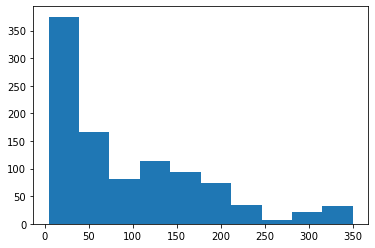

In [238]:
plt.hist(target_cpc)